In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive"

 110946.docx
 ALPR_project
 ALPR_web.zip
 ANPR.zip
 Car-License-Plate-Recognition
'Centric - initial cloud packages.docx'
'Colab Notebooks'
 cudnn-11.2-windows-x64-v8.1.0.77.zip
'Getting started.pdf'
'Irene Ogalo-cover letter.doc'
'Irene Ogalo-cover letter.gdoc'
'KONE Motorcycle service fees (1).pdf'
'KONE Motorcycle service fees.gdoc'
'KONE Motorcycle service fees.pdf'
 multimedia
'OGALO DAVID.pdf'
 RealEstate
'Sidian Thika Branch with discount.docx'
'Sidian Thika Branch with discount.gdoc'
 skydash.zip
 Sokoni
'user manual.gdoc'
 volley


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/ALPR_project')

In [4]:
from local_utils import detect_lp

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [6]:
!pip install utils
from utils import *

In [7]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
#libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [9]:
import sys
import traceback

In [10]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [11]:
wpod_net_path = "/content/drive/MyDrive/ALPR_project/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [12]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 11 images...


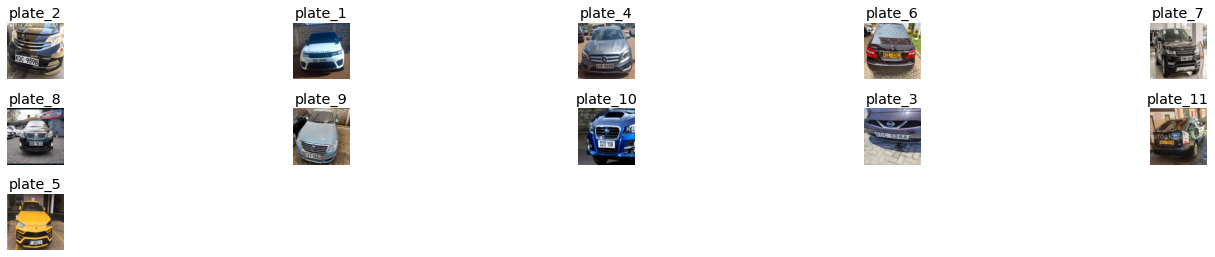

In [13]:
# Create a list of image paths 
image_paths = glob.glob("/content/drive/MyDrive/ALPR_project/Plates_dataset/*.jpg")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(20,12))
cols = 5
rows = 10
# fig_list = list(range(100))
# fig_list = [100]
fig_list = []
for i in range(len(image_paths)):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()


Detect 1 plate(s) in plate_6
Coordinate of plate(s) in image: 
 [array([[332.10486057, 674.682828  , 674.4613399 , 331.88337247],
       [396.7088549 , 398.68215413, 496.25541806, 494.28211883],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


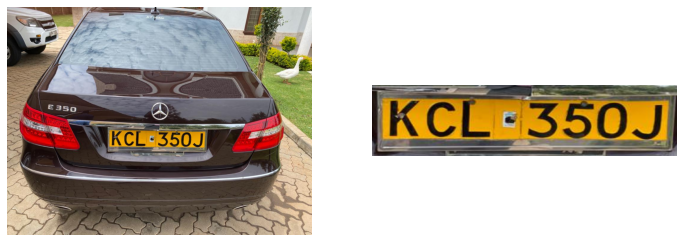

In [14]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=300):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
# array with images
test_image = image_paths[3]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


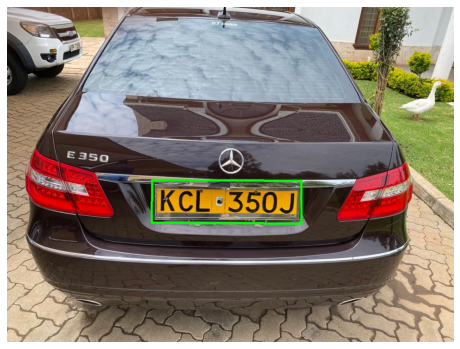

In [15]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

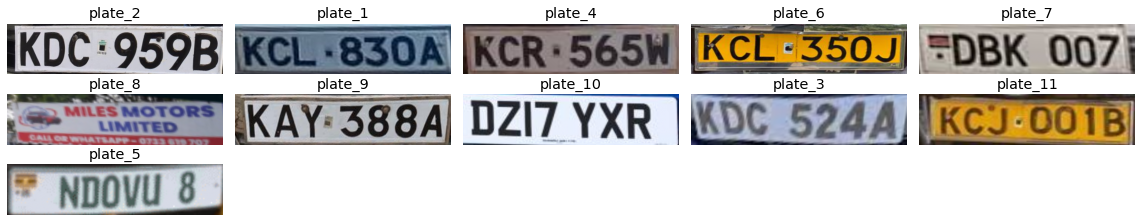

In [16]:
# Viualize all obtained plate images 

fig = plt.figure(figsize=(16,10))
cols = 5
rows = 10
fig_list = []

for i in range(len(image_paths)):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    # cropimage
    LpImg, _ = get_plate(image_paths[i])
    # print(get_plate(image_paths[i]))
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()

In [17]:
# Extract license plate from photos

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

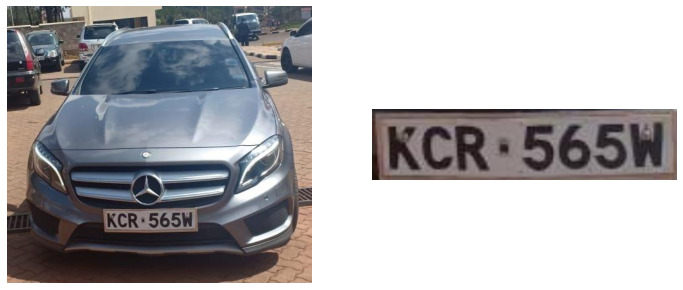

In [18]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=300):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

#test_image_path
test_image_path = "/content/drive/MyDrive/ALPR_project/Plates_dataset/plate_4.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

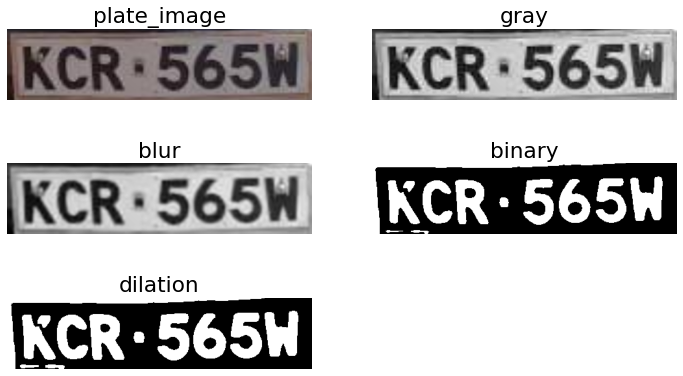

In [19]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

Detect 7 letters...


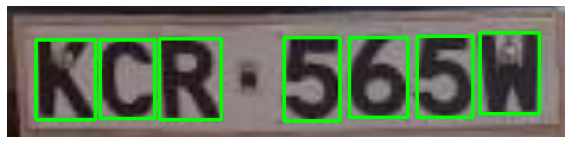

In [20]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 40, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)


# # image = cv2.imread(path) 
# start_point = (5, 5) 
# end_point = (220, 220) 
# color = (255, 0, 0) 
# thickness = 2
# # Using cv2.rectangle() method 
# # Draw a rectangle with blue line borders of thickness of 2 px 
# image = cv2.rectangle(test_roi, start_point, end_point, color, thickness)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300

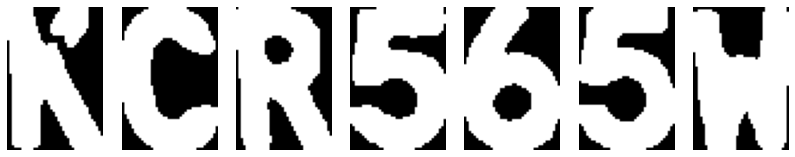

In [21]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")  

In [22]:
# Load model architecture, weight and labels
json_file = open('/content/drive/MyDrive/ALPR_project/MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/MyDrive/ALPR_project/License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('/content/drive/MyDrive/ALPR_project/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [23]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

KCR565V


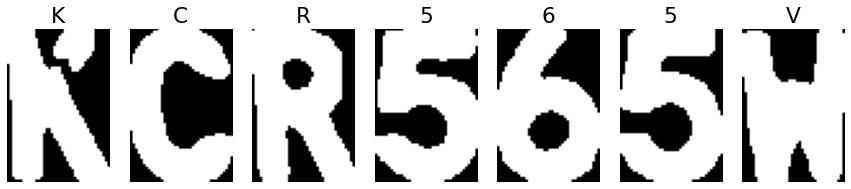

In [24]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)